# Anomaly Detection and Recommender Systems

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 14.0)
np.set_printoptions(suppress = True)

## Anomaly detection

#### Import data and visualize

In [33]:
data1 = loadmat('data/ex8data1.mat')

In [34]:
def plot_data(X):
    plt.plot(data1['X'][:,0], data1['X'][:,1], 'bx', markersize = 3.5)
    plt.axis([0, 30, 0, 30])
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')

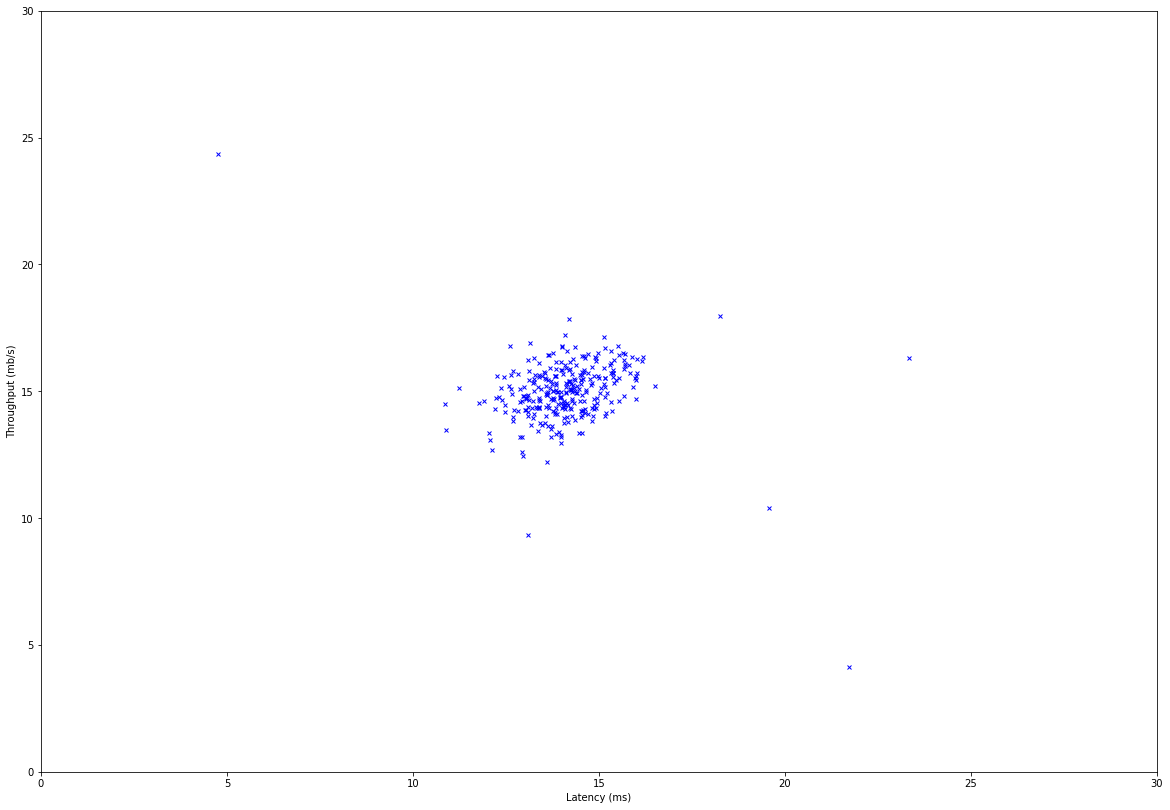

In [35]:
plot_data(data1['X'])

#### Estimate parameters for a Gaussian distribution

In [5]:
def estimate_gaussian(X):
    return X.mean(axis = 0), np.cov(X.T)

In [6]:
mu, sigma2 = estimate_gaussian(data1['X'])
print(mu, sigma2)

[14.11222578 14.99771051] [[ 1.83862041 -0.22786456]
 [-0.22786456  1.71533273]]


In [7]:
def mva_gaussian(X, mu, sigma2):
    k = len(mu)
    
    if sigma2.ndim == 1:
        sigma2 = np.diag(sigma2)
        
    X = X - mu
    
    return (2 * np.pi)**(-k/2) * np.linalg.det(sigma2)**(-0.5) * \
        np.exp( -0.5 * np.sum( np.multiply( X.dot( np.linalg.inv(sigma2) ), X ), axis=1 ) ).reshape( ( X.shape[0], 1 ) )

In [8]:
p = mva_gaussian(data1['X'], mu, sigma2)

print(p.shape)

(307, 1)


In [9]:
def plot_fit(X, mu, sigma2):
    
    x = y = np.arange(0, 30, 0.5)
    xx, yy = np.meshgrid(x, y)
    
    z = mva_gaussian(np.vstack((xx.ravel(), yy.ravel())).T, mu, sigma2)
    z = z.reshape(xx.shape)
    
    levels = [10**a for a in range(-20, 0, 3)]
    
    plt.contour(xx, yy, z, levels = levels)

Text(0.5,1,'Gaussian fit')

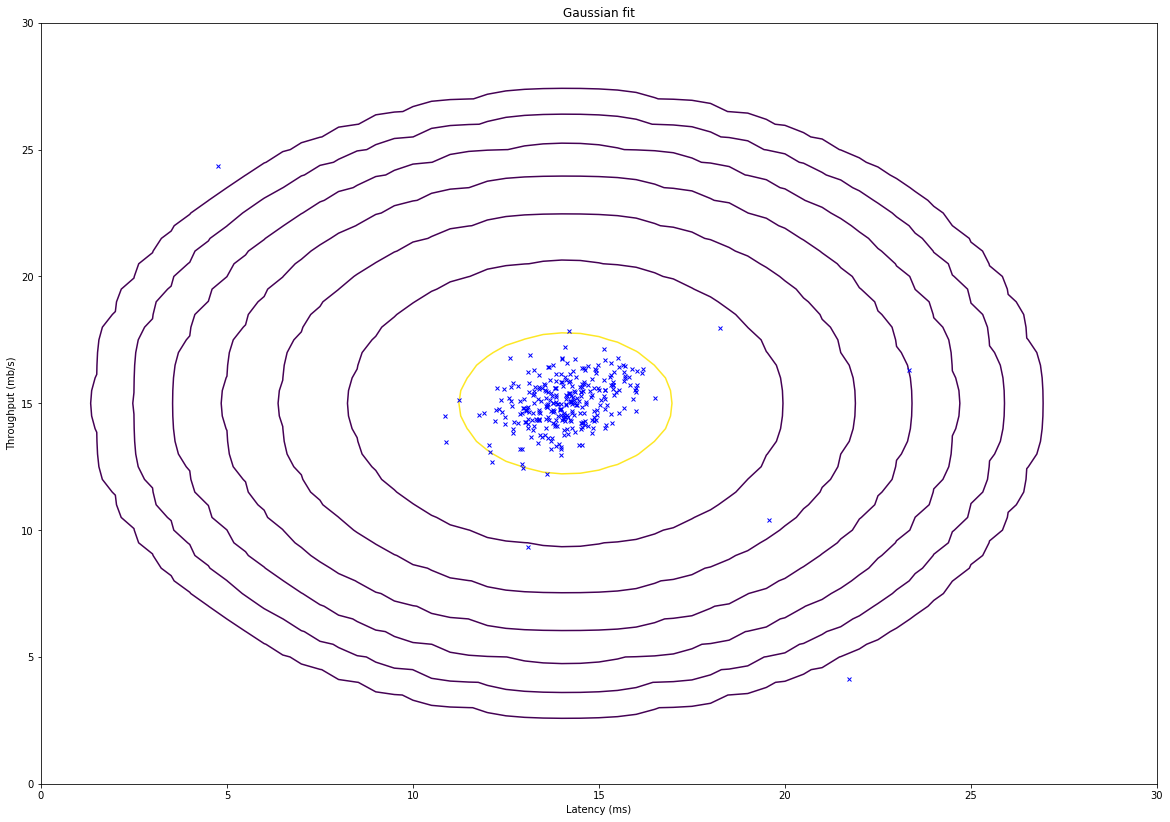

In [36]:
plot_data(data1['X'])

plot_fit(data1['X'], mu, np.diag(sigma2))

plt.title('Gaussian fit')

Text(0.5,1,'Multivariate Gaussiant fit')

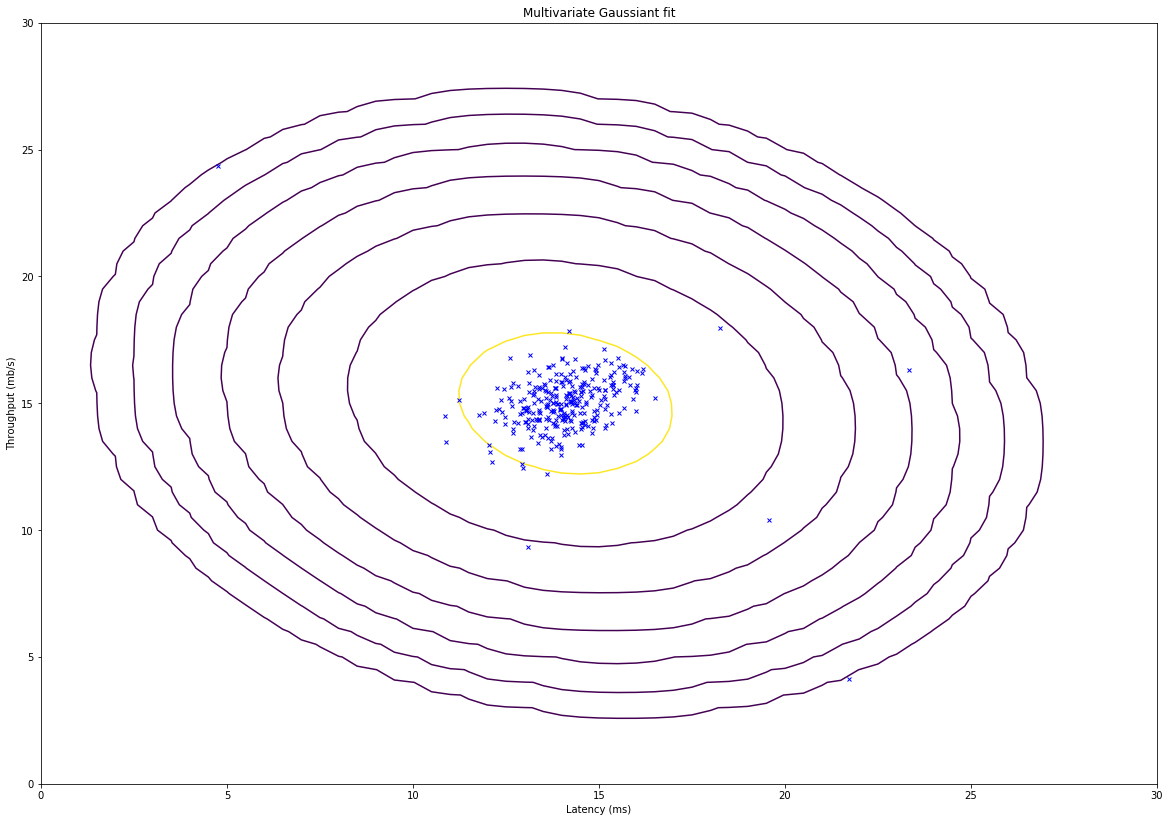

In [37]:
plot_data(data1['X'])

plot_fit(data1['X'], mu, sigma2)

plt.title('Multivariate Gaussiant fit')

#### Select threshold

In [12]:
def select_threshold(yval, pval):
    
    best_epsilon = 0
    best_F1 = 0
    
    for eps in np.linspace(np.amin(pval), np.amax(pval), 1000):
        
        cv_predictions = pval < float(eps)
        
        if len(cv_predictions) < 1:
            continue
            
        tp = np.sum(np.logical_and((cv_predictions == 1), (yval == 1)))
        fp = np.sum(np.logical_and((cv_predictions == 1), (yval == 0)))
        fn = np.sum(np.logical_and((cv_predictions == 0), (yval == 1)))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2 * prec * rec) / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = float(eps)
            
    return best_epsilon, best_F1

In [13]:
pval = mva_gaussian(data1['X'], mu, sigma2)

In [14]:
epsilon, f1 = select_threshold(data1['yval'], pval)

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [15]:
outliers = mva_gaussian(data1['X'], mu, sigma2)[:,0] < epsilon

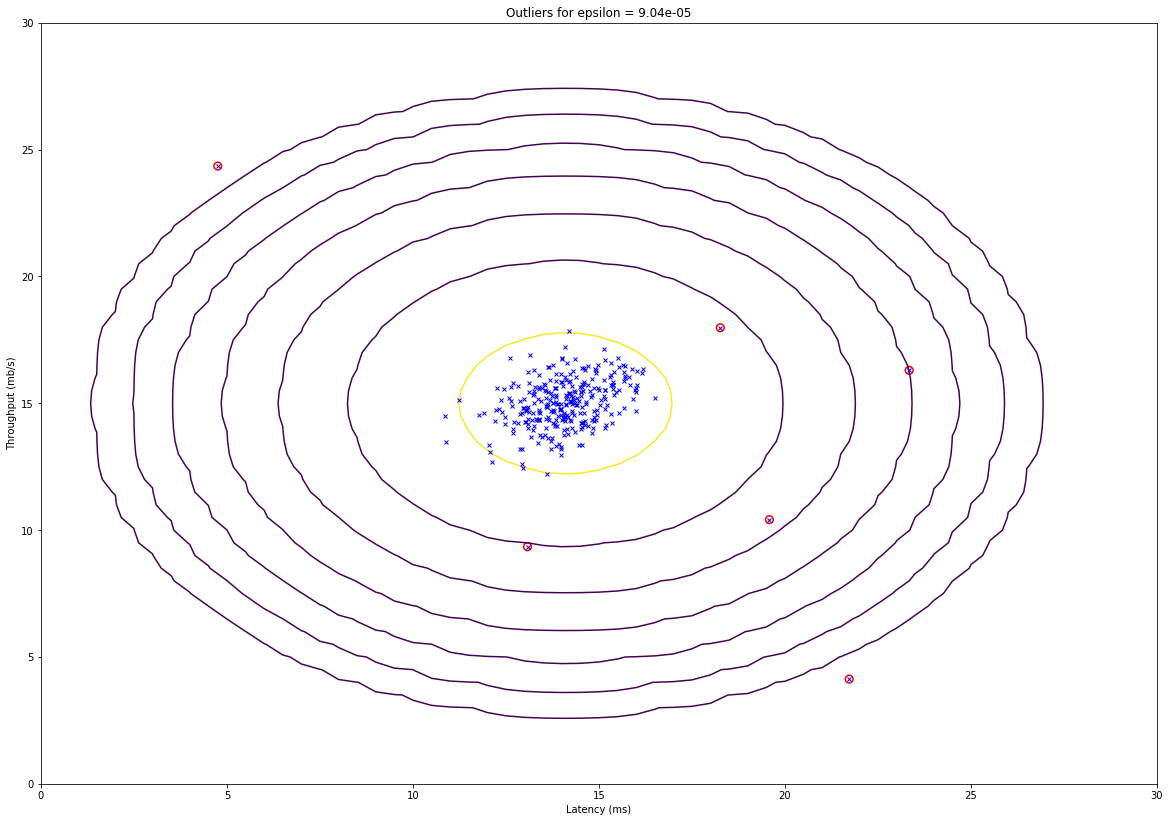

In [38]:
width = 1
precision = 3

plot_data(data1['X'])

plot_fit(data1['X'], mu, np.diag(sigma2))

plt.title(f'Outliers for epsilon = {epsilon:{width}.{precision}}')

plt.scatter(data1['X'][outliers][:,0], data1['X'][outliers][:,1], s = 60, edgecolors = 'r', facecolors = 'None', linewidth = 1.5)

#### High dimensional dataset

In [17]:
hd_data = loadmat('data/ex8data2.mat')

In [18]:
mu_hd, sigma2_hd = estimate_gaussian(hd_data['X'])

In [19]:
p_hd = mva_gaussian(hd_data['X'], mu_hd, np.diag(sigma2_hd))

In [20]:
pval_hd = mva_gaussian(hd_data['Xval'], mu_hd, np.diag(sigma2_hd))

In [21]:
epsilon_hd, f1_hd = select_threshold(hd_data['yval'], pval_hd)

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [22]:
print( 'Best epsilon: ', epsilon_hd )
print( 'Best F1 score:', f1_hd )
print( 'Number of outliers found: ', np.sum( p_hd < epsilon_hd ) )

Best epsilon:  1.3730337086887016e-18
Best F1 score: 0.6153846153846154
Number of outliers found:  117


## Recommender Systems

#### Import and visualize data

In [23]:
movies_data = loadmat('data/ex8_movies.mat')

In [24]:
print('Average rating for Toy Story: ', round( np.mean( movies_data['Y'][0][movies_data['R'][0].astype(bool)] ), 2 ))

Average rating for Toy Story:  3.88


Text(0,0.5,'Movies')

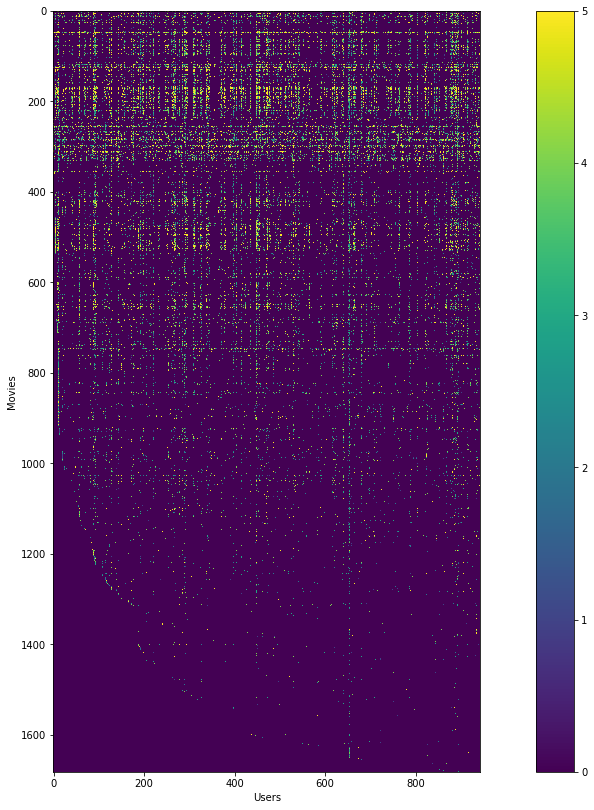

In [39]:
plt.imshow(movies_data['Y'])
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

#### Collaborative filtering

In [26]:
def cofi_cost_func( params, Y, R, num_users, num_movies, num_features, lmda ):
    
    X = params[:num_movies*num_features].reshape( (num_movies, num_features) )
    Theta = params[num_movies*num_features:].reshape( (num_users, num_features) )
   
    X_grad = np.zeros( (X.shape) )
    Theta_grad = np.zeros( (Theta.shape) )
    
    J = np.sum(np.square( np.multiply( X.dot(Theta.T) - Y, R ) )) / 2
    X_grad = np.multiply( X.dot(Theta.T) - Y, R ).dot(Theta) + lmda * X
    Theta_grad = np.multiply( X.dot(Theta.T) - Y, R ).T.dot(X) + lmda * Theta
    
    reg_x = (lmda/2) * np.sum( np.square(X) ) 
    reg_theta = (lmda/2) * np.sum( np.square(Theta) ) 
    
    return ( J + reg_x + reg_theta, np.concatenate( ( X_grad.ravel(), Theta_grad.ravel() ) ) )

In [27]:
movie_params = loadmat('data/ex8_movieParams.mat')

In [28]:
# Reduce dataset size

num_users = 4 
num_movies = 5 
num_features = 3

X = movie_params['X'][0:num_movies, 0:num_features]
Theta = movie_params['Theta'][0:num_users, 0:num_features]
Y = movies_data['Y'][0:num_movies, 0:num_users]
R = movies_data['R'][0:num_movies, 0:num_users]

In [29]:
J, grad = cofi_cost_func( np.concatenate(( X.ravel(), Theta.ravel() )), Y, R, num_users, num_movies, num_features, 0 )

print(J)

22.224603725685675


In [30]:
J, grad = cofi_cost_func( np.concatenate(( X.ravel(), Theta.ravel() )), Y, R, num_users, num_movies, num_features, 1.5 )

print( 'Cost with lambda = 1.5: ', round( J, 2 ) )

Cost with lambda = 1.5:  31.34


#### Learning movie recommendations

In [31]:
movie_idx = []

f = open('data/movie_ids.txt' , encoding = "ISO-8859-1") 

for line in f:
    tmp = line.split( ' ', 1 )
    movie_idx.append( tmp[1].splitlines()[0] )

print(movie_idx[0:4])

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)']


In [40]:
# Additional ratings were provided in the exercise

my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [41]:
my_ratings_R = my_ratings > 0

In [42]:
Y = np.c_[ movies_data['Y'], my_ratings ]
R = np.c_[ movies_data['R'], my_ratings_R ]

print(Y.shape)
print(R.shape)

(1682, 944)
(1682, 944)


In [43]:
def normalize_ratings( Y, R ):
    
    Y_mean = np.sum( Y, axis=1 ) / np.sum( R, axis=1 )
    Y_mean = Y_mean.reshape( ( Y_mean.shape[0], 1) )
    
    return Y - Y_mean, Y_mean

In [44]:
Y_norm, Y_mean = normalize_ratings( Y, R )

num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [45]:
X = np.random.randn( num_movies, num_features )
Theta = np.random.randn( num_users, num_features )

initial_params = np.concatenate( (X.ravel(), Theta.ravel()) )

lmda = 10
theta = minimize( fun = cofi_cost_func, x0 = initial_params, 
              args = (Y_norm, R, num_users, num_movies, num_features, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 100} )

In [46]:
theta

     fun: 38954.05026434991
     jac: array([ 0.0255913 ,  0.00177816,  0.01316917, ...,  0.0003882 ,
       -0.00199159,  0.00018932])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 151
     nit: 100
    njev: 151
  status: 1
 success: False
       x: array([-1.22339844,  0.019431  ,  0.57397682, ..., -0.03254643,
       -0.05056478, -0.03721292])

In [47]:
X = theta.x[:num_movies*num_features].reshape( (num_movies, num_features) )
Theta = theta.x[num_movies*num_features:].reshape( (num_users, num_features) )


print(X.shape, Theta.shape)

(1682, 10) (944, 10)


In [48]:
pred = X.dot(Theta.T)
my_pred = pred[:,-1].reshape( (pred.shape[0], 1) ) + Y_mean

my_pred_sorted = np.sort(my_pred, axis=0)[::-1]

my_pred_idx = np.argsort(my_pred, axis=0)[::-1]

print(my_pred_sorted[:10])
print(my_pred_idx[:10])

[[5.00000057]
 [5.00000033]
 [5.00000025]
 [5.00000011]
 [5.0000001 ]
 [5.00000004]
 [5.00000003]
 [4.99999994]
 [4.99999973]
 [4.99999955]]
[[1188]
 [1121]
 [1598]
 [1652]
 [1292]
 [1535]
 [1499]
 [1200]
 [ 813]
 [1466]]


In [49]:
print('Top recommendations for you:')

width = 1
precision = 2
for i in range(10):
    rating = my_pred[int(my_pred_idx[i])][0]
    name = movie_idx[int(my_pred_idx[i])]
    print (f'Predicting rating {rating:{width}.{precision}} for movie {name}')
    
print('\nOriginal ratings provided:')
for i in range( len(my_ratings) ):
    if my_ratings[i] > 0:
        print (f'Rated {int(my_ratings[i])} for movie {movie_idx[i]}')

Top recommendations for you:
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)

Original ratings provided:
Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of

#### Without normalization

In [50]:
X = np.random.randn( num_movies, num_features )
Theta = np.random.randn( num_users, num_features )

initial_params = np.concatenate( (X.ravel(), Theta.ravel()) )

lmda = 10
theta = minimize( fun = cofi_cost_func, x0 = initial_params, 
              args = (Y, R, num_users, num_movies, num_features, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 100} )

In [51]:
theta

     fun: 72009.58806971594
     jac: array([-0.29849468,  0.11857242, -0.36258332, ...,  0.04079528,
        0.03203278,  0.0213602 ])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 150
     nit: 100
    njev: 150
  status: 1
 success: False
       x: array([-0.4894492 ,  0.67725819,  0.44281358, ...,  0.83673141,
       -0.12617762,  0.37408624])

In [52]:
X = theta.x[:num_movies*num_features].reshape( (num_movies, num_features) )
Theta = theta.x[num_movies*num_features:].reshape( (num_users, num_features) )

print(X.shape, Theta.shape)

(1682, 10) (944, 10)


In [53]:
pred = X.dot(Theta.T)
my_pred = pred[:,-1].reshape( (pred.shape[0], 1) ) + Y_mean

my_pred_sorted = np.sort(my_pred, axis=0)[::-1]

my_pred_idx = np.argsort(my_pred, axis=0)[::-1]

print(my_pred_sorted[:10])
print(my_pred_idx[:10])

[[8.55915392]
 [8.484123  ]
 [8.36100705]
 [8.27627904]
 [8.20885848]
 [8.17006824]
 [8.10956439]
 [8.09152877]
 [8.06242943]
 [8.05716905]]
[[ 49]
 [312]
 [ 63]
 [173]
 [317]
 [271]
 [ 11]
 [171]
 [126]
 [ 21]]


In [54]:
print('Top recommendations for you:')

width = 1
precision = 2
for i in range(10):
    rating = my_pred[int(my_pred_idx[i])][0]
    name = movie_idx[int(my_pred_idx[i])]
    print (f'Predicting rating {rating:{width}.{precision}} for movie {name}')
    
print('\nOriginal ratings provided:')
for i in range( len(my_ratings) ):
    if my_ratings[i] > 0:
        print (f'Rated {int(my_ratings[i])} for movie {movie_idx[i]}')

Top recommendations for you:
Predicting rating 8.6 for movie Star Wars (1977)
Predicting rating 8.5 for movie Titanic (1997)
Predicting rating 8.4 for movie Shawshank Redemption, The (1994)
Predicting rating 8.3 for movie Raiders of the Lost Ark (1981)
Predicting rating 8.2 for movie Schindler's List (1993)
Predicting rating 8.2 for movie Good Will Hunting (1997)
Predicting rating 8.1 for movie Usual Suspects, The (1995)
Predicting rating 8.1 for movie Empire Strikes Back, The (1980)
Predicting rating 8.1 for movie Godfather, The (1972)
Predicting rating 8.1 for movie Braveheart (1995)

Original ratings provided:
Rated 4 for movie Toy Story (1995)
Rated 3 for movie Twelve Monkeys (1995)
Rated 5 for movie Usual Suspects, The (1995)
Rated 4 for movie Outbreak (1995)
Rated 5 for movie Shawshank Redemption, The (1994)
Rated 3 for movie While You Were Sleeping (1995)
Rated 5 for movie Forrest Gump (1994)
Rated 2 for movie Silence of the Lambs, The (1991)
Rated 4 for movie Alien (1979)
Rated